In [160]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Data && Parameter settings

### Hyper parameters

In [161]:
interval = '4h'
shift_interval = -3 # 몇 번째 후를 예측할지
patience = 20
# lr = 0.0002
# epochs = 600

In [162]:
# Load data
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False, parse_dates=['timestamp'])
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

In [163]:
# scenario 2: bear only
# btc_data = btc_data[(btc_data['timestamp'] >= '2021-11-10') & (btc_data['timestamp'] <= '2023-01-05')]

In [164]:
def calculate_rsi(df, window=14):
    delta = df['close'].diff(1)  # Price changes between each day
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Calculate average gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Calculate average losses
    rs = gain / loss  # Relative Strength (RS)
    rsi = 100 - (100 / (1 + rs))  # RSI formula
    df['rsi'] = rsi
    return df

In [165]:
btc_data = calculate_rsi(btc_data)

# MACD

In [166]:
btc_data['EMA_12'] = btc_data['close'].ewm(span=12, adjust=False).mean()
btc_data['EMA_26'] = btc_data['close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
btc_data['MACD_Line'] = btc_data['EMA_12'] - btc_data['EMA_26']

# Calculate Signal Line (9-period EMA of MACD Line)
btc_data['Signal_Line'] = btc_data['MACD_Line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
btc_data['MACD_Histogram'] = btc_data['MACD_Line'] - btc_data['Signal_Line']

btc_data = btc_data.drop(columns=['EMA_12', 'EMA_26'])

In [167]:
features = ['open', 'high', 'low', 'close', 'volume', 'rsi']
features_MACD = ['MACD_Line', 'Signal_Line', 'MACD_Histogram']
features_MA = ['MA_30', 'MA_60', 'MA_90', 'MA_120', 'MA_260'] # for 4h
# features_MA = ['MA_40', 'MA_60', 'MA_90', 'MA_120', 'MA_200'] # for 1h or 15m chart
features += features_MACD + features_MA 

In [168]:
btc_data.head()

,timestamp,open,high,low,close,volume,MA_30,MA_60,MA_90,MA_120,MA_260,rsi,MACD_Line,Signal_Line,MACD_Histogram
0,2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,NaN,NaN,NaN,NaN,NaN,NaN,6.167179,1.233436,4.933744
2,2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,NaN,NaN,NaN,NaN,NaN,NaN,4.949019,1.976553,2.972466
3,2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,NaN,NaN,NaN,NaN,NaN,NaN,1.775599,1.936362,-0.160762
4,2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,NaN,NaN,NaN,NaN,NaN,NaN,-3.933782,0.762333,-4.696115


# Shift data (predict next close)

In [169]:
# Shift the 'close' column values forward by one space
btc_data['next_close'] = btc_data['close'].shift(shift_interval)

# Display the first few rows to check the result
# btc_data[['timestamp', 'close', 'close_shifted']].head()

## Processing Nan data

In [170]:
data_filled = btc_data.ffill()
# data_filled = data_filled.bfill()
data_filled = data_filled.dropna()

# Get the maximum window size from MA columns
ma_columns = features_MA
ma_window_sizes = [int(col.split('_')[1]) for col in features_MA]
max_ma_window = max(ma_window_sizes) # 1020

# Remove the initial rows where moving averages are NaN
# data_cleaned = btc_data.iloc[max_ma_window:]
data_filled = data_filled[:-3]

In [171]:
data_filled.tail()

,timestamp,open,high,low,close,volume,MA_30,MA_60,MA_90,MA_120,MA_260,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
15675,2024-10-14 08:00:00,64620.87,65188.57,64340.98,64920.06,5338.83523,62187.694333,62314.088333,62366.102333,62992.319333,60813.831423,74.083282,590.973297,358.896712,232.076585,66083.99
15676,2024-10-14 12:00:00,64920.05,66299.93,64660.56,65870.00,11165.96157,62306.161000,62380.704333,62367.420778,63014.902750,60842.259731,77.535302,743.515759,435.820521,307.695238,65400.00
15677,2024-10-14 16:00:00,65870.00,66072.30,65459.00,65939.40,5541.11281,62469.741667,62440.227667,62367.205000,63028.628250,60871.870808,77.129577,860.092152,520.674848,339.417305,65638.74
15678,2024-10-14 20:00:00,65939.41,66500.00,65730.00,66083.99,3881.13909,62651.340667,62506.860833,62372.560333,63043.805667,60902.128462,76.811137,953.159559,607.171790,345.987769,65399.69
15679,2024-10-15 00:00:00,66084.00,66330.00,65324.40,65400.00,3574.82599,62802.497667,62565.827667,62381.963889,63051.639000,60928.613077,70.052957,960.650095,677.867451,282.782645,67571.80


# Sequences

In [172]:
def create_sequences(features, target, sequence_length=10):
    X = []
    y = []
    for i in range(sequence_length, len(features) - abs(shift_interval)):
        X.append(features[i - sequence_length:i])
        y.append(target[i + abs(shift_interval) - 1])
    return np.array(X), np.array(y)

# Train test split

In [173]:
# Split data before scaling
from sklearn.model_selection import train_test_split

features_data = data_filled[features]
target_data = data_filled[['next_close']]
# X_train_features, X_test_features, y_train_target, y_test_target = train_test_split(features_data, target_data, test_size=0.1, shuffle=False)
train_end = int(len(features_data) * 0.8)
val_end = int(len(features_data) * 0.9)

# Split the data
X_train_features = features_data[:train_end]
X_val_features = features_data[train_end:val_end]
X_test_features = features_data[val_end:]

y_train_target = target_data[:train_end]
y_val_target = target_data[train_end:val_end]
y_test_target = target_data[val_end:]

# Fit scalers on training data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
# scaler_val = MinMaxScaler()

# Scaling
X_train_scaled = scaler_X.fit_transform(X_train_features)
X_val_scaled = scaler_X.transform(X_val_features)
X_test_scaled = scaler_X.transform(X_test_features)

y_train_scaled = scaler_y.fit_transform(y_train_target)
y_val_scaled = scaler_y.transform(y_val_target)
y_test_scaled = scaler_y.transform(y_test_target)

# Create sequences
sequence_length = 10  # Adjust as needed
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled, sequence_length)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, sequence_length)


In [174]:
X_train.shape

(12326, 10, 14)

In [175]:
y_train.shape

(12326, 1)

In [176]:
X_test.shape

(1533, 10, 14)

In [177]:
y_test.shape

(1533, 1)

In [178]:
btc_data.tail()

,timestamp,open,high,low,close,volume,MA_30,MA_60,MA_90,MA_120,MA_260,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
15678,2024-10-14 20:00:00,65939.41,66500.0,65730.0,66083.99,3881.13909,62651.340667,62506.860833,62372.560333,63043.805667,60902.128462,76.811137,953.159559,607.171790,345.987769,65399.69
15679,2024-10-15 00:00:00,66084.00,66330.0,65324.4,65400.00,3574.82599,62802.497667,62565.827667,62381.963889,63051.639000,60928.613077,70.052957,960.650095,677.867451,282.782645,67571.80
15680,2024-10-15 04:00:00,65399.99,65846.0,65201.0,65638.74,3319.36953,62960.455667,62625.203500,62393.927556,63066.600750,60960.678000,70.214870,974.615957,737.217152,237.398805,NaN
15681,2024-10-15 08:00:00,65638.74,65850.0,65280.0,65399.69,3798.65244,63098.378667,62678.865000,62411.485889,63079.614750,60990.130615,73.320664,955.381620,780.850046,174.531575,NaN
15682,2024-10-15 12:00:00,65399.68,67950.0,65383.5,67571.80,6878.70128,63324.460000,62768.934000,62456.045778,63113.582583,61028.683731,80.299100,1102.698176,845.219672,257.478504,NaN


In [179]:
print(f"Type of X_train: {type(X_train)}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Data type of X_train elements: {X_train.dtype}")

Type of X_train: <class 'numpy.ndarray'>
Shape of X_train: (12326, 10, 14)
Data type of X_train elements: float64


# Check NaN

In [180]:
def check_for_nans_and_infs(data, name):
    nan_count = np.isnan(data).sum()
    inf_count = np.isinf(data).sum()
    print(f"{name} - NaNs: {nan_count}, Infs: {inf_count}")

# Check X_train
check_for_nans_and_infs(X_train, 'X_train')

# Check y_train
check_for_nans_and_infs(y_train, 'y_train')

# Check X_test
check_for_nans_and_infs(X_test, 'X_test')

# Check y_test
check_for_nans_and_infs(y_test, 'y_test')
check_for_nans_and_infs(X_train_scaled, 'X_train_scaled')
check_for_nans_and_infs(y_train_scaled, 'y_train_scaled')


X_train - NaNs: 0, Infs: 0
y_train - NaNs: 0, Infs: 0
X_test - NaNs: 0, Infs: 0
y_test - NaNs: 0, Infs: 0
X_train_scaled - NaNs: 0, Infs: 0
y_train_scaled - NaNs: 0, Infs: 0


# Model & train (Keras)

In [181]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

params = {'batch_size': 32, 'epochs': 300, 'model__dropout_rate': 0.3, 'model__lr': 0.0001, 'model__unit': 128}

# Define the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(params['model__unit'], return_sequences=True))
model.add(Dropout(params['model__dropout_rate']))
model.add(LSTM(params['model__unit']))
model.add(Dropout(params['model__dropout_rate']))
model.add(Dense(1))

optimizer = Adam(learning_rate=params['model__lr'])
# model.compile(optimizer=optimizer, loss='mean_squared_error')
model.compile(optimizer=optimizer, loss='mean_absolute_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

start_time = time.time()
history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_val, y_val), callbacks=[early_stopping])
end_time = time.time()
print(f"Time taken to fit the model: {end_time - start_time} seconds")

Epoch 1/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0656 - val_loss: 0.0088
Epoch 2/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0247 - val_loss: 0.0079
Epoch 3/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0213 - val_loss: 0.0089
Epoch 4/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0208 - val_loss: 0.0085
Epoch 5/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0198 - val_loss: 0.0102
Epoch 6/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0186 - val_loss: 0.0116
Epoch 7/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0183 - val_loss: 0.0154
Epoch 8/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0181 - val_loss: 0.0082
Epoch 9/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0181 - val_loss: 0.0075
Epoch 10/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0173 - val_loss: 0.0094
Epoch 11/300
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0171 - val_loss: 0.0086
Epoch 12/300
386/386 ━━━━━━━━━━━━━━━━━━━━

# Keras (GridSearch)

In [182]:
# import numpy as np
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
# # from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from scikeras.wrappers import KerasRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, make_scorer
# from sklearn.model_selection import TimeSeriesSplit

# # Define the model creation function
# def create_lstm_model(unit=256, dropout_rate=0.2, lr=lr, optimizer='adam'):
#     model = Sequential()
#     model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(LSTM(unit, return_sequences=True))
#     model.add(Dropout(dropout_rate))
#     model.add(LSTM(unit))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1))
    
#     # Compile the model
#     optimizer = Adam(learning_rate=lr)
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model

# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# rmse_scorer = make_scorer(rmse, greater_is_better=False)

# # Wrap the model using KerasRegressor
# model = KerasRegressor(model=create_lstm_model, verbose=0)

# # Define the grid of hyperparameters
# # param_grid = {
# #     'model__unit': [128, 256, 512, 1024],
# #     'model__dropout_rate': [0, 0.2, 0.3],
# #     'batch_size': [32, 64],
# #     'epochs': [100, 150, 200, 250, 300],
# #     'model__lr': [0.001, 0.0001, 0.0003, 0.003, 0.01, 0.03]
# # }

# param_grid = {
#     'model__unit': [128],
#     'model__dropout_rate': [0.2],
#     'batch_size': [32, 64],
#     'epochs': [100, 150],
#     'model__lr': [0.001, 0.01]
# }

# # print(model.get_params().keys())
# # assert()

# # Set up GridSearchCV
# tscv = TimeSeriesSplit(n_splits=5)

# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=tscv, scoring=rmse_scorer)

# # Fit the grid search
# grid_result = grid.fit(X_train, y_train)

# # Output the best parameters and score
# print("Best parameters found: ", grid_result.best_params_)
# print("Best score achieved: ", grid_result.best_score_)
# model = grid_result.best_estimator_

# Model & train (torch)

In [183]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np

# # Assuming you have variables `X_train`, `y_train`, `lr`, `epochs`, and `patience` defined
# # Convert your training data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# # Calculate the split index for sequential splitting
# validation_split = 0.2  # Same as validation_split=0.2 in Keras
# dataset_size = len(X_train_tensor)
# split_index = int(dataset_size * (1 - validation_split))

# # Sequentially split the data
# X_train_seq = X_train_tensor[:split_index]
# y_train_seq = y_train_tensor[:split_index]
# X_val_seq = X_train_tensor[split_index:]
# y_val_seq = y_train_tensor[split_index:]

# # Create TensorDatasets
# train_dataset = TensorDataset(X_train_seq, y_train_seq)
# val_dataset = TensorDataset(X_val_seq, y_val_seq)

# # Create DataLoaders for batching without shuffling
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Define the LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size=50, dropout_rate=0.2):
#         super(LSTMModel, self).__init__()
#         self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         # First LSTM layer with return_sequences=True
#         out, _ = self.lstm1(x)
#         out = self.dropout1(out)
#         # Second LSTM layer
#         out, _ = self.lstm2(out)
#         out = out[:, -1, :]  # Take the output of the last time step
#         out = self.dropout2(out)
#         # Fully connected layer
#         out = self.fc(out)
#         return out

# # Initialize the model, loss function, and optimizer
# input_size = X_train.shape[2]  # Number of features
# model = LSTMModel(input_size=input_size, hidden_size=50, dropout_rate=0.2)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device = torch.device("mps" if torch.backends.mps.is_built() or torch.backends.mps.is_available() else 'cpu')
# model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# # Implement early stopping
# best_val_loss = float('inf')
# patience_counter = 0
# best_model_state = None

# train_loss_history = []
# val_loss_history = []

# for epoch in range(epochs):
#     # Training phase
#     model.train()
#     train_losses = []
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs.view(-1), y_batch)
#         loss.backward()
#         optimizer.step()

#         train_losses.append(loss.item())

#     avg_train_loss = np.mean(train_losses)
#     train_loss_history.append(avg_train_loss)

#     # Validation phase
#     model.eval()
#     val_losses = []
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch = X_batch.to(device)
#             y_batch = y_batch.to(device)

#             outputs = model(X_batch)
#             loss = criterion(outputs.view(-1), y_batch)
#             val_losses.append(loss.item())

#     avg_val_loss = np.mean(val_losses)
#     val_loss_history.append(avg_val_loss)

#     print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

#     # Check for early stopping
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         best_model_state = model.state_dict()
#         patience_counter = 0
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

# # Restore the best model weights
# model.load_state_dict(best_model_state)

# Figure

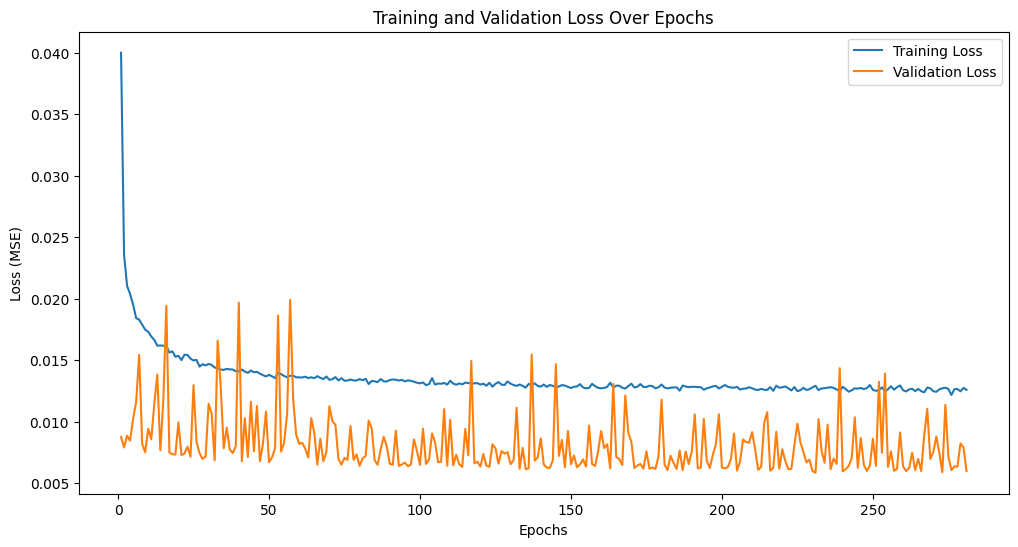

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Size up the figure

# epochs_range = range(1, len(train_loss_history) + 1)  # Get the range of epochs
# plt.plot(epochs_range, train_loss_history, label='Training Loss')
# plt.plot(epochs_range, val_loss_history, label='Validation Loss')

epochs = range(1, len(history.history['loss']) + 1)  # Get number of epochs

plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')  # Annotate x-axis with epochs
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

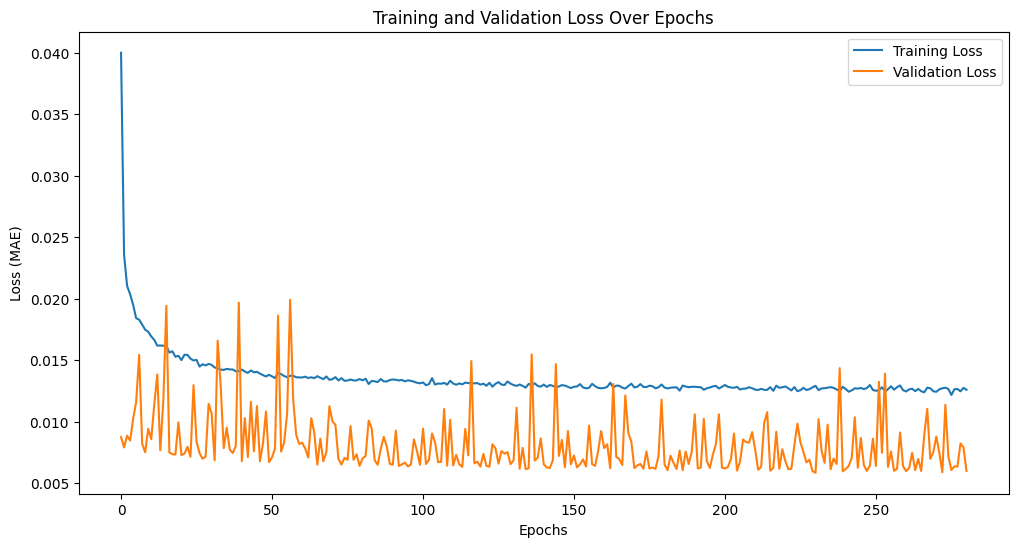

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

#

# Prediction

In [185]:
# Ensure that your model is in evaluation mode
# model.eval()

# Convert X_test to a PyTorch tensor and move it to the appropriate device
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Make predictions without computing gradients
# with torch.no_grad():
    # y_pred = model(X_test_tensor)

# Move predictions to CPU and convert to NumPy array
# y_pred = y_pred.cpu().numpy()

y_pred = model.predict(X_test)

# Get the index of 'next_close' in the features list
# close_index = features.index('next_close')

# Inverse transform
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


# Backtesting

In [186]:
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
btc_holdings = 0
positions = []

btc_data_tail_df = btc_data.tail(y_test.shape[0])
base_price = btc_data_tail_df['close'].iloc[0]
final_price = btc_data_tail_df['close'].iloc[-1]
base_portfolio_value = ((final_price - base_price) / base_price + 1) * initial_balance
print(f"Baseline portfilio value: {base_portfolio_value:,.2f} USDT")  

for i in range(len(y_pred_actual)):
    current_time = btc_data_tail_df['timestamp'].iloc[i]
    predicted_price = y_pred_actual[i]
    # current_price = y_test_actual[i]
    current_price = btc_data_tail_df['close'].iloc[i]

    if predicted_price > current_price:
        # Buy signal
        if balance > 0:
            btc_holdings = balance / current_price
            balance = 0
            positions.append(('Buy', current_price))
            print(f"{current_time}: Bought BTC at {current_price:,.2f}, holding {btc_holdings:.4f} BTC")
    else:
        # Sell signal
        if btc_holdings > 0:
            balance = btc_holdings * current_price
            btc_holdings = 0
            positions.append(('Sell', current_price))
            print(f"{current_time}: Sold BTC at {current_price:,.2f}, now holding {balance:,.2f} USDT")

# Calculate final portfolio value
final_balance = balance + btc_holdings * y_test_actual[-1][0]
profit = final_balance - initial_balance
# print(f"Initial Balance: {initial_balance:,.2f}")
# print(f"Profit: {profit:,.2f}")
print(f"Final Balance: {final_balance:,.2f}")

if final_balance > base_portfolio_value:
    print("Out Performed !!!!!!!!")

Baseline portfilio value: 15,695.01 USDT
2024-02-03 08:00:00: Bought BTC at 42,995.04, holding 0.2326 BTC
2024-02-03 12:00:00: Sold BTC at 43,119.06, now holding 10,028.85 USDT
2024-02-03 16:00:00: Bought BTC at 43,061.09, holding 0.2329 BTC
2024-02-05 04:00:00: Sold BTC at 43,071.88, now holding 10,031.36 USDT
2024-02-05 20:00:00: Bought BTC at 42,708.70, holding 0.2349 BTC
2024-02-06 04:00:00: Sold BTC at 42,890.00, now holding 10,073.94 USDT
2024-02-07 04:00:00: Bought BTC at 42,918.03, holding 0.2347 BTC
2024-02-07 12:00:00: Sold BTC at 43,071.08, now holding 10,109.87 USDT
2024-02-10 08:00:00: Bought BTC at 47,182.00, holding 0.2143 BTC
2024-02-10 12:00:00: Sold BTC at 47,353.48, now holding 10,146.61 USDT
2024-02-13 12:00:00: Bought BTC at 48,727.47, holding 0.2082 BTC
2024-02-13 20:00:00: Sold BTC at 49,699.59, now holding 10,349.04 USDT
2024-02-14 00:00:00: Bought BTC at 49,518.61, holding 0.2090 BTC
2024-02-14 04:00:00: Sold BTC at 49,838.93, now holding 10,415.98 USDT
2024-02

MAE: 1726.50
RMSE: 2081.96
MSE: 4334554.78
R²: 0.8798


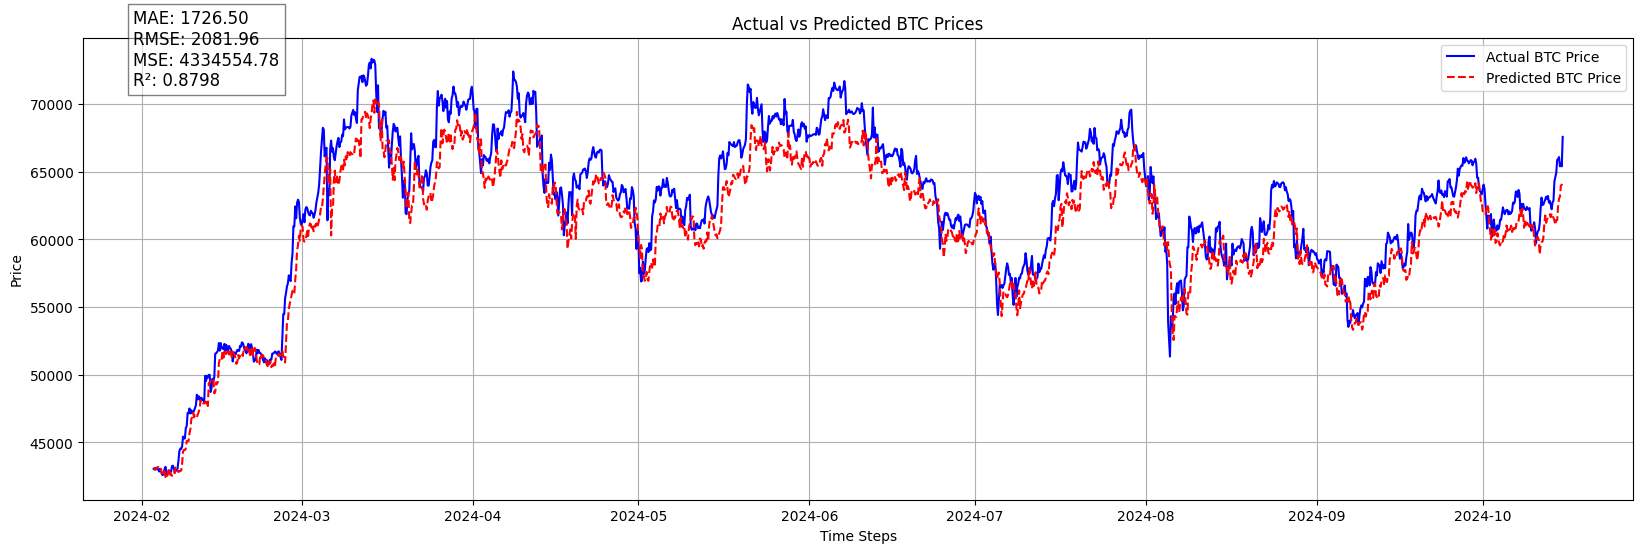

In [187]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

textstr = '\n'.join((
    f'MAE: {mae:.2f}',
    f'RMSE: {rmse:.2f}',
    f'MSE: {mse:.2f}',
    f'R²: {r2:.4f}',
))

print(textstr)

plt.figure(figsize=(20, 6))

# plt.plot(y_test_actual, color='blue', label='Actual BTC Price')
# plt.plot(btc_data_tail_df.timestamp, y_test_actual, color='blue', label='Actual BTC Price')
plt.plot(btc_data_tail_df.timestamp, btc_data_tail_df.close, color='blue', label='Actual BTC Price')
plt.plot(btc_data_tail_df.timestamp, y_pred_actual, color='red', linestyle='--', label='Predicted BTC Price')
plt.title('Actual vs Predicted BTC Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Display metrics in the plot
plt.gcf().text(0.15, 0.8, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()